# CNN Pytorch

Обучите CNN (самописная) на CIFAR-100.

Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.

*Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.

In [1]:
import numpy as np
import torch
from torch.nn import functional as F
from torch import nn
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/


In [3]:
class MyOwnCifar(torch.utils.data.Dataset):

    def __init__(self, init_dataset, transform=None):
        self.dataset = init_dataset
        self.transform = transform


    def __len__(self):
        return len(self.dataset)


    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [5]:
transform_train = transforms.Compose([
    transforms.Resize(40),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor()]
                                     )

In [6]:
def train_valid_split(data):
    X_train, X_test = train_test_split(data, test_size=0.1, random_state=1)

    return X_train, X_test

In [7]:
train, valid = train_valid_split(dataset)

train_dataset = MyOwnCifar(train, transform_train)
valid_dataset = MyOwnCifar(valid, transforms.ToTensor())

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

In [9]:
classes = ['apples', 'aquarium fish', 'baby', 'bear', 'beaver', 'bed',
            'bee', 'beetle', 'bicycle', 'bottles', 'bowls', 'boy', 'bridge',
            'bus', 'butterfly', 'camel', 'cans', 'castle', 'caterpillar', 
            'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 
            'couch', 'crab', 'crocodile', 'cups', 'dinosaur', 'dolphin', 
            'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 
            'keyboard', 'kangaroo', 'lamp', 'lawn-mower', 'leopard', 'lion', 
            'lizard', 'lobster', 'man', 'maple', 'motorcycle', 'mountain', 
            'mouse', 'mushrooms', 'oak', 'oranges', 'orchids', 'otter', 'palm', 
            'pears', 'pickup truck', 'pine', 'plain', 'plates', 'poppies',
            'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
            'roses', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper',
            'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflowers',
            'sweet peppers', 'table', 'tank', 'telephone','television',
            'tiger', 'tractor', 'train', 'trout', 'tulips', 'turtle',
            'wardrobe', 'whale', 'willow', 'wolf', 'woman', 'worm']

caterpillar


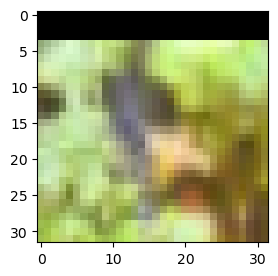

In [10]:
plt.figure(figsize=(3,3))
for img, label in train_loader:
    print(classes[label[0]])
    plt.imshow(img[0].permute(1,2,0))
    plt.show()
    break

In [11]:
dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [32]:
class ModelNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.dp = nn.Dropout(0.3)

        self.bn1 = nn.BatchNorm2d(3)
        self.cv1 = nn.Conv2d(3, 128, 3)
        self.bn2 = nn.BatchNorm2d(128)
        self.cv2 = nn.Conv2d(128, 256, 3)
        self.bn3 = nn.BatchNorm2d(256)
        self.cv3 = nn.Conv2d(256, 512, 3)
        self.bn4 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.out = nn.Linear(512, 100)

    
    def forward(self, x):
        x = self.bn1(x)
        x = self.cv1(x)
        x = F.leaky_relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn2(x)
        x = self.cv2(x)
        x = F.leaky_relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn3(x)
        x = self.cv3(x)
        x = F.leaky_relu(x)
        x = F.max_pool2d(x, 2)

        x = self.bn4(x)
        x = x.view(x.size(0), -1)
        x = self.dp(x)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.dp(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.out(x)
        return F.softmax(x, dim=1)


model = ModelNet().to(dev)
print(model)

ModelNet(
  (dp): Dropout(p=0.3, inplace=False)
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=100, bias=True)
)


In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [34]:
# !pip install torchsummary

In [35]:
from torchsummary import summary

summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2          [-1, 128, 30, 30]           3,584
       BatchNorm2d-3          [-1, 128, 15, 15]             256
            Conv2d-4          [-1, 256, 13, 13]         295,168
       BatchNorm2d-5            [-1, 256, 6, 6]             512
            Conv2d-6            [-1, 512, 4, 4]       1,180,160
       BatchNorm2d-7            [-1, 512, 2, 2]           1,024
           Dropout-8                 [-1, 2048]               0
            Linear-9                 [-1, 1024]       2,098,176
          Dropout-10                 [-1, 1024]               0
           Linear-11                  [-1, 512]         524,800
           Linear-12                  [-1, 100]          51,300
Total params: 4,154,986
Trainable params: 4,154,986
Non-trainable params: 0
---------------------------

In [36]:
# Функция обучения и отрисовки точности модели

def model_train(model, num_epochs, optimizer, criterion, train_loader, valid_loader):

    train_accuracy = []
    test_accuracy = []
    epochs = []

    for epoch in range(num_epochs):
        running_loss, running_items, running_right = 0.0, 0.0, 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(dev), data[1].to(dev)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_items += len(labels)
            running_right += (labels == torch.max(outputs, 1)[1]).sum()

            if ((i % 351 == 0) | (i % 150 == 0)) & (i != 0):
                print(f'Epoch [{epoch+1}/{num_epochs}]. '\
                    f'Step [{i + 1}/{len(train_loader)}]. '\
                    f'Loss: {running_loss / running_items:.3f}. ' \
                    f'Acc: {running_right / running_items:.3f}', end='. ')

                test_running_right, test_running_total = 0.0, 0.0
                for data in valid_loader:
                    test_outputs = model(data[0].to(dev))
                    test_running_total += len(data[1])
                    test_running_right += (data[1].to(dev) == torch.max(test_outputs, 1)[1]).sum()
                
                print(f'Test acc: {test_running_right / test_running_total:.3f}')

            model.train()

            
        train_accuracy.append(float(running_right / running_items))
        test_accuracy.append(float(test_running_right / test_running_total))
        epochs.append(epoch+1)

    print('Training is finished')

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracy, 'r-', label='train')
    plt.plot(epochs, test_accuracy, 'r--', label='test')
    plt.legend()
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    return train_accuracy, test_accuracy, epochs

Epoch [1/15]. Step [151/352]. Loss: 0.036. Acc: 0.038. Test acc: 0.061
Epoch [1/15]. Step [301/352]. Loss: 0.036. Acc: 0.053. Test acc: 0.078
Epoch [1/15]. Step [352/352]. Loss: 0.036. Acc: 0.056. Test acc: 0.095
Epoch [2/15]. Step [151/352]. Loss: 0.035. Acc: 0.083. Test acc: 0.101
Epoch [2/15]. Step [301/352]. Loss: 0.035. Acc: 0.086. Test acc: 0.097
Epoch [2/15]. Step [352/352]. Loss: 0.035. Acc: 0.088. Test acc: 0.107
Epoch [3/15]. Step [151/352]. Loss: 0.035. Acc: 0.099. Test acc: 0.108
Epoch [3/15]. Step [301/352]. Loss: 0.035. Acc: 0.099. Test acc: 0.117
Epoch [3/15]. Step [352/352]. Loss: 0.035. Acc: 0.101. Test acc: 0.117
Epoch [4/15]. Step [151/352]. Loss: 0.035. Acc: 0.106. Test acc: 0.117
Epoch [4/15]. Step [301/352]. Loss: 0.035. Acc: 0.108. Test acc: 0.125
Epoch [4/15]. Step [352/352]. Loss: 0.035. Acc: 0.108. Test acc: 0.127
Epoch [5/15]. Step [151/352]. Loss: 0.035. Acc: 0.117. Test acc: 0.132
Epoch [5/15]. Step [301/352]. Loss: 0.035. Acc: 0.116. Test acc: 0.135
Epoch 

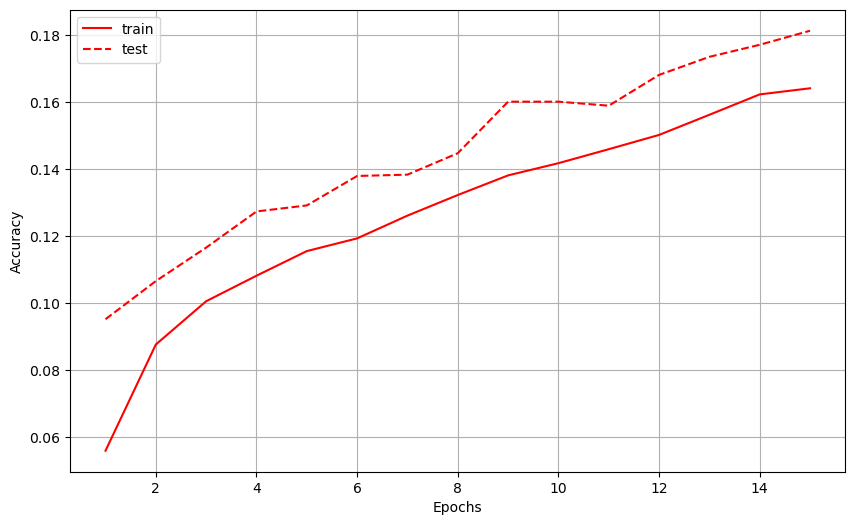

In [37]:
num_epochs = 15
model.train()

model_train_acc, model_test_acc, n_epoch = model_train(model,num_epochs, 
                                                       optimizer=optimizer,
                                                       criterion=criterion,
                                                       train_loader=train_loader,
                                                       valid_loader=valid_loader)

### Resnet_34

In [42]:
from torchvision import models

resnet_34 = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

for param in list(resnet_34.parameters()):
    param.requires_grad = False

resnet_34.fc = nn.Linear(512, 100)

resnet_34 = resnet_34.to(dev)


train_actions = transforms.Compose([transforms.Resize(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

train, valid = train_valid_split(dataset)

train_dataset = MyOwnCifar(train, train_actions)
valid_dataset = MyOwnCifar(valid, valid_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False)

params_to_update = []
for name, param in resnet_34.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

Epoch [1/15]. Step [151/352]. Loss: 0.025. Acc: 0.293. Test acc: 0.467
Epoch [1/15]. Step [301/352]. Loss: 0.021. Acc: 0.399. Test acc: 0.524
Epoch [1/15]. Step [352/352]. Loss: 0.020. Acc: 0.418. Test acc: 0.535
Epoch [2/15]. Step [151/352]. Loss: 0.013. Acc: 0.574. Test acc: 0.550
Epoch [2/15]. Step [301/352]. Loss: 0.013. Acc: 0.578. Test acc: 0.567
Epoch [2/15]. Step [352/352]. Loss: 0.013. Acc: 0.580. Test acc: 0.576
Epoch [3/15]. Step [151/352]. Loss: 0.011. Acc: 0.612. Test acc: 0.578
Epoch [3/15]. Step [301/352]. Loss: 0.011. Acc: 0.613. Test acc: 0.573
Epoch [3/15]. Step [352/352]. Loss: 0.011. Acc: 0.613. Test acc: 0.581
Epoch [4/15]. Step [151/352]. Loss: 0.010. Acc: 0.637. Test acc: 0.581
Epoch [4/15]. Step [301/352]. Loss: 0.010. Acc: 0.632. Test acc: 0.584
Epoch [4/15]. Step [352/352]. Loss: 0.010. Acc: 0.632. Test acc: 0.589
Epoch [5/15]. Step [151/352]. Loss: 0.010. Acc: 0.644. Test acc: 0.587
Epoch [5/15]. Step [301/352]. Loss: 0.010. Acc: 0.640. Test acc: 0.584
Epoch 

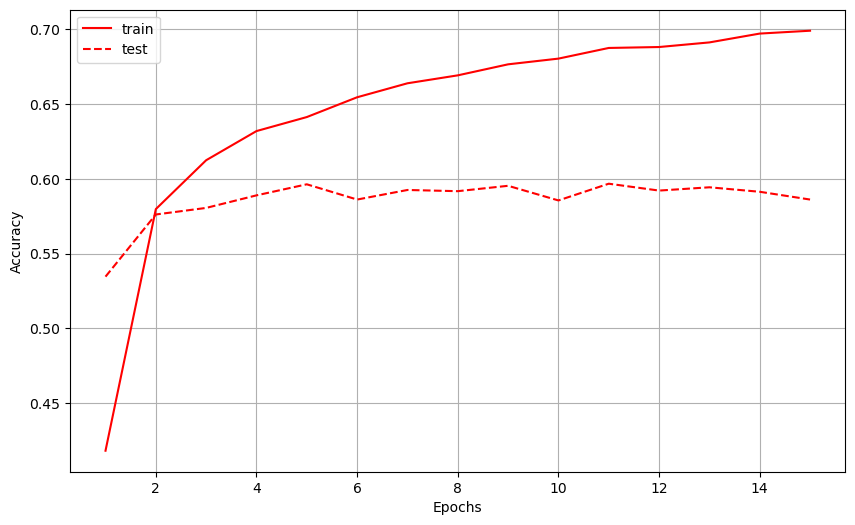

CPU times: user 32min 43s, sys: 4min 38s, total: 37min 22s
Wall time: 37min 30s


In [43]:
%%time

# Обучение модели resnet_34

optimizer = torch.optim.Adam(params_to_update)
criterion = nn.CrossEntropyLoss()

num_epochs = 15
resnet_34.train()


resnet34_train_acc, resnet34_test_acc, n_epoch = model_train(resnet_34, num_epochs, 
                                                             optimizer=optimizer,
                                                             criterion=criterion,
                                                             train_loader=train_loader,
                                                             valid_loader=valid_loader)

### Resnet_101

Epoch [1/7]. Step [151/352]. Loss: 0.021. Acc: 0.389. Test acc: 0.536
Epoch [1/7]. Step [301/352]. Loss: 0.017. Acc: 0.477. Test acc: 0.585
Epoch [1/7]. Step [352/352]. Loss: 0.017. Acc: 0.492. Test acc: 0.596
Epoch [2/7]. Step [151/352]. Loss: 0.011. Acc: 0.625. Test acc: 0.600
Epoch [2/7]. Step [301/352]. Loss: 0.011. Acc: 0.624. Test acc: 0.613
Epoch [2/7]. Step [352/352]. Loss: 0.011. Acc: 0.624. Test acc: 0.603
Epoch [3/7]. Step [151/352]. Loss: 0.010. Acc: 0.654. Test acc: 0.616
Epoch [3/7]. Step [301/352]. Loss: 0.010. Acc: 0.651. Test acc: 0.629
Epoch [3/7]. Step [352/352]. Loss: 0.010. Acc: 0.652. Test acc: 0.636
Epoch [4/7]. Step [151/352]. Loss: 0.009. Acc: 0.674. Test acc: 0.629
Epoch [4/7]. Step [301/352]. Loss: 0.009. Acc: 0.673. Test acc: 0.636
Epoch [4/7]. Step [352/352]. Loss: 0.009. Acc: 0.672. Test acc: 0.637
Epoch [5/7]. Step [151/352]. Loss: 0.009. Acc: 0.686. Test acc: 0.632
Epoch [5/7]. Step [301/352]. Loss: 0.009. Acc: 0.684. Test acc: 0.627
Epoch [5/7]. Step [3

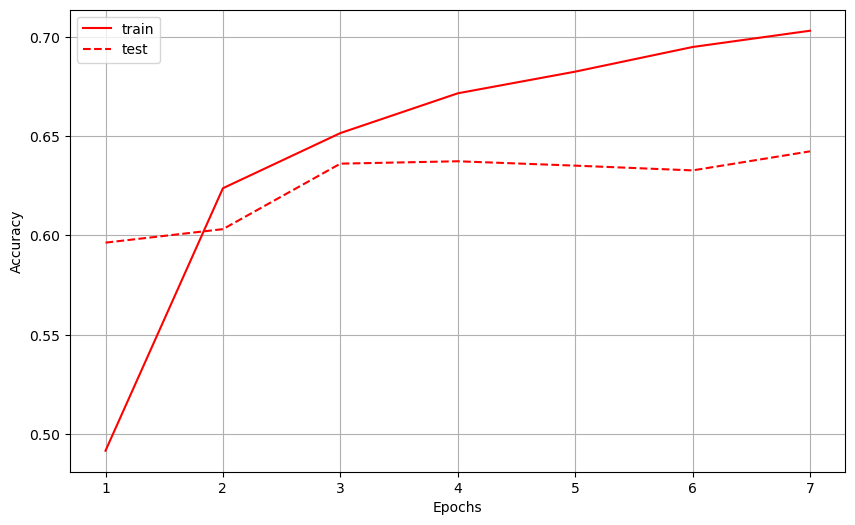

CPU times: user 27min 2s, sys: 2min 12s, total: 29min 14s
Wall time: 29min 20s


In [45]:
%%time

# Обучение модели resnet_101

resnet_101 = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

for param in list(resnet_101.parameters()):
    param.requires_grad = False

resnet_101.fc = nn.Linear(2048, 100)

resnet_101 = resnet_101.to(dev)

params_to_update = []
for name, param in resnet_101.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 7 # исходя из графика точности модели на валидации можно понять, что после 5 эпох точность не увеличивается
resnet_101.train()

resnet101_train_acc, resnet101_test_acc, n_epoch = model_train(resnet_101, num_epochs, 
                                                               optimizer=optimizer,
                                                               criterion=criterion,
                                                               train_loader=train_loader,
                                                               valid_loader=valid_loader)

### Resnet 151

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Epoch [1/5]. Step [151/352]. Loss: 0.025. Acc: 0.333. Test acc: 0.469
Epoch [1/5]. Step [301/352]. Loss: 0.021. Acc: 0.425. Test acc: 0.538
Epoch [1/5]. Step [352/352]. Loss: 0.020. Acc: 0.443. Test acc: 0.554
Epoch [2/5]. Step [151/352]. Loss: 0.012. Acc: 0.612. Test acc: 0.572
Epoch [2/5]. Step [301/352]. Loss: 0.012. Acc: 0.615. Test acc: 0.584
Epoch [2/5]. Step [352/352]. Loss: 0.012. Acc: 0.618. Test acc: 0.590
Epoch [3/5]. Step [151/352]. Loss: 0.010. Acc: 0.675. Test acc: 0.603
Epoch [3/5]. Step [301/352]. Loss: 0.010. Acc: 0.673. Test acc: 0.611
Epoch [3/5]. Step [352/352]. Loss: 0.010. Acc: 0.673. Test acc: 0.602
Epoch [4/5]. Step [151/352]. Loss: 0.009. Acc: 0.712. Test acc: 0.601
Epoch [4/5]. Step [301/352]. Loss: 0.009. Acc: 0.709. Test acc: 0.615
Epoch [4/5]. Step [352/352]. Loss: 0.009. Acc: 0.708. Test acc: 0.619
Epoch [5/5]. Step [151/352]. Loss: 0.008. Acc: 0.736. Test acc: 0.615
Epoch [5/5]. Step [301/352]. Loss: 0.008. Acc: 0.733. Test acc: 0.622
Epoch [5/5]. Step [3

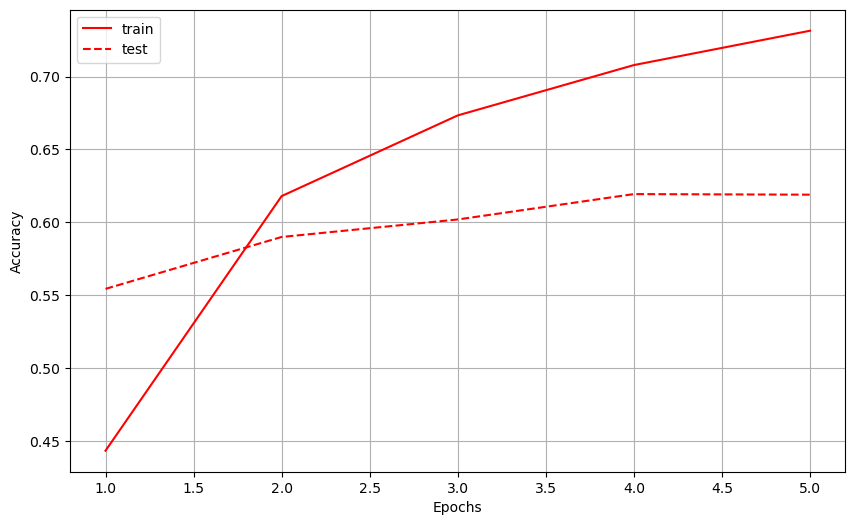

CPU times: user 24min 23s, sys: 1min 32s, total: 25min 56s
Wall time: 26min 10s


In [47]:
%%time

# Обучение модели resnet_152

resnet_152 = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)

for param in list(resnet_152.parameters()):
    param.requires_grad = False

resnet_152.fc = nn.Linear(2048, 100)

resnet_152 = resnet_152.to(dev)

params_to_update = []
for name, param in resnet_152.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 5 
resnet_152.train()

resnet152_train_acc, resnet152_test_acc, n_epoch = model_train(resnet_152, num_epochs, 
                                                               optimizer=optimizer,
                                                               criterion=criterion,
                                                               train_loader=train_loader,
                                                               valid_loader=valid_loader)

In [50]:
n_epoch = [i for i in range(0, 15)]

In [51]:
n_epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

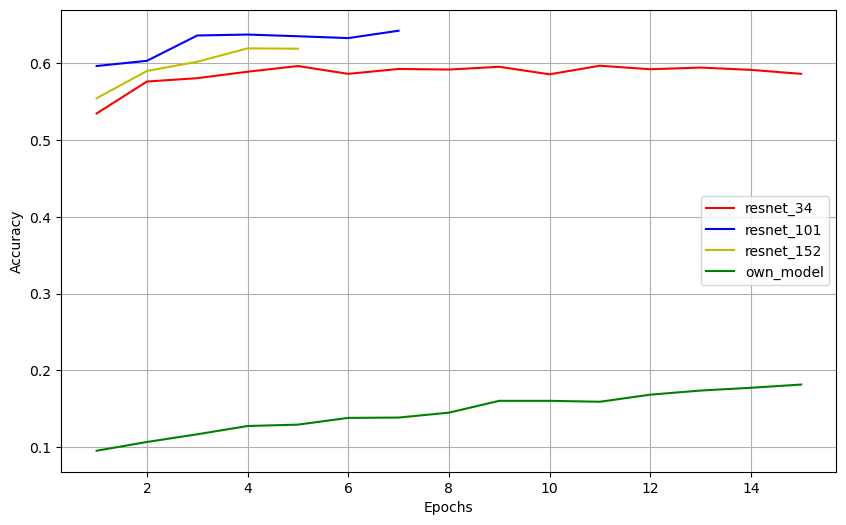

In [54]:
n_epoch = [i+1 for i in range(0, 15)]

plt.figure(figsize=(10, 6))
plt.plot(n_epoch, resnet34_test_acc, 'r', label='resnet_34')
plt.plot(n_epoch[:7], resnet101_test_acc, 'b', label='resnet_101')
plt.plot(n_epoch[:5], resnet152_test_acc, 'y', label='resnet_152')
plt.plot(n_epoch, model_test_acc, 'g', label='own_model')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Из графика следует, что при меньшем количестве времени и эпох лучшей предтренированной моделью ялвяется Resnet101